In [138]:
import numpy as np
import pandas as pd
import librosa
import os
import glob
import re
import seaborn as sn
import matplotlib.pyplot as plt
import scipy
import time
import collections
import keras
import random
from keras.utils import np_utils
from keras.layers import MaxPooling1D, Conv1D, Conv2D, MaxPooling2D, GlobalAveragePooling2D, LSTM, ELU, Bidirectional, Attention
from keras.layers import Dense, Dropout, Activation, Flatten, CuDNNLSTM
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import tensorflow as tf
import pickle
from keras.utils.vis_utils import plot_model
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import keras_tuner
from keras import backend as K
import shutil
import os
import tensorflow_addons as tfa
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
from sklearn import metrics

### Global variables

In [139]:
global_model_type = 'cnn'
global_folder_name = 'weyo4'
file_suffix = 'weyo1'
global_batch_size = 32
global_epochs = 30
global_learning_rate = 0.0001
own_file_path = os.getcwd() 

In [140]:
def instrument_code(filename):
    """
    Function that takes in a filename and returns instrument based on naming convention
    """
    # Synth lead borttagen. id = 9
    class_names=['bass', 'brass', 'flute', 'guitar', 
             'keyboard', 'mallet', 'organ', 'reed', 
             'string', 'vocal']
    
    for name in class_names:
        if name in filename:
            return class_names.index(name)
    else:
        return None

## Get data

In [141]:
def get_data_from_file(file):
    with open(file, "rb") as f:
        X_train_full  = pickle.load(f)

    X_train = []
    y_train = []

    for (key, value) in X_train_full:
        X_train.append(value)
        y_train.append(instrument_code(key))

    X_train_numpy = np.array(X_train)
    y_train_numpy = np.array(y_train)
    return (X_train_numpy, y_train_numpy)

In [142]:
def get_old_test_data(file):
    with open(file, 'rb') as f:
        old_X_test_full = pickle.load(f)

    old_X_test = []
    old_y_test = []

    for(key, value) in old_X_test_full.items():
        #temporal_value = np.mean(value, axis = 1)
        old_X_test.append(value)
        old_y_test.append(instrument_code(key))
        
    old_y_test_numpy = np.asarray(old_y_test)
    old_X_test_numpy = np.asarray(old_X_test)
    return (old_X_test_numpy, old_y_test_numpy)

### Calculate metrics

In [143]:
def calc_metrics(y_true, y_pred):
    print(metrics.classification_report(y_true, y_pred, digits=3))

In [144]:
def build_cnn_model():    
    input_shape = (126, 13, 1)
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128,(3, 3), padding='same', activation='relu'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    return model

In [145]:
def build_lstm_model():
    model = Sequential()
    #model.add(Bidirectional(CuDNNLSTM(128, return_sequences=True), input_shape=(126, 128)))
    #model.add(CuDNNLSTM(4, input_shape=(126, 128), return_sequences=True))
    #model.add(Dropout(0.5))
    model.add(LSTM(32, input_shape=(126, 13), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(32, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(32, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(32, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(32, return_sequences=True))
    #model.add(LSTM(16, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    return model

In [146]:
def plot_acc_loss(history, acc_file_path, loss_file_path):
    # Taget från https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    # summarize history for accuracy
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(acc_file_path)
    plt.show()

    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(loss_file_path)
    plt.show()

In [147]:
    
def plt_confusion_matrix(model, X_test, y_test, confusion_matrix_file_path):    
    y_prediction = model.predict(X_test)
    y_prediction = np.argmax(y_prediction, axis = 1)
    result = confusion_matrix(y_test, y_prediction , normalize='pred')

    df_cm = pd.DataFrame(result, index = [i for i in ["bass", "brass", "flute", "guitar", "keyboard", "mallet", "organ", "reed", "string", "vocal"]],
                    columns = [i for i in ["bass", "brass", "flute", "guitar", "keyboard", "mallet", "organ", "reed", "string", "vocal"]])

    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    plt.savefig(confusion_matrix_file_path)
    plt.show()

In [148]:
def run_cnn(fold_index):

    old_test_file = 'CustomDataFull/testdata2000.pkl'

    train_file = 'folds/' + str(fold_index) + 'train_' + file_suffix
    test_file = 'folds/' + str(fold_index) + 'test_' + file_suffix
    valid_file = 'folds/' + str(fold_index) + 'valid_' + file_suffix

    X_train, y_train = get_data_from_file(train_file)
    X_test, y_test = get_data_from_file(test_file)
    X_valid, y_valid = get_data_from_file(valid_file)
    old_X_test, old_y_test = get_old_test_data(old_test_file)

    fold_path = 'results/cnn_results/' + global_folder_name + '/' + str(fold_index) + file_suffix + '/'
    if not os.path.exists(fold_path):
        os.makedirs(fold_path)

    model = build_cnn_model()
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=global_learning_rate), metrics=['accuracy'])
    model.summary()
    history = model.fit(x=X_train, y=y_train, validation_data=(X_valid, y_valid), batch_size=global_batch_size, epochs=global_epochs, shuffle=True, verbose=2)
    model.save(fold_path + str(fold_index) + 'model_' + file_suffix + '.h5')

    history_name = fold_path + str(fold_index) + 'history_' + file_suffix + '.history'

    with open(history_name, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

    scores = model.evaluate(X_test, y_test, verbose=1)
    y_prediction = model.predict(X_test)
    y_prediction = np.argmax(y_prediction, axis = 1)

    print("\n\ny_test : ", y_test)
    print("\n\ny_prediction : ", y_prediction)

    f1_scores = metrics.classification_report(y_test, y_prediction, digits=3)

    original_scores = model.evaluate(old_X_test, old_y_test, verbose=1)
    original_y_prediction = model.predict(old_X_test)
    original_y_prediction = np.argmax(original_y_prediction, axis = 1)
    original_f1_scores = metrics.classification_report(old_y_test, original_y_prediction, digits=3)

    score_file = fold_path + str(fold_index) + 'score_' + file_suffix + '.txt'
    with open(score_file, 'w') as f:
        f.write('fold: ' + str(fold_index) + '\n')
        f.write('scores: ' + str(scores) + '\n')
        f.write('scores with original testdata: ' + str(original_scores) + '\n')
        f.write('f1_scores:\n' + str(f1_scores) + '\n')
        f.write('f1_scores with original testdata:\n' + str(original_f1_scores) + '\n')

    loss_file_path = fold_path + str(fold_index) + 'loss_' + file_suffix + '.png'
    acc_file_path = fold_path + str(fold_index) + 'acc_' + file_suffix + '.png'
    plot_acc_loss(history.history, acc_file_path, loss_file_path)

    confusion_matrix_file_path = fold_path + str(fold_index) + 'confusion_matrix_' + file_suffix + '.png'
    plt_confusion_matrix(model, X_test, y_test, confusion_matrix_file_path)

In [149]:
def run_lstm(fold_index):
    old_test_file = 'CustomDataFull/testdata2000.pkl'
    train_file = 'folds/' + str(fold_index) + 'train_' + file_suffix
    test_file = 'folds/' + str(fold_index) + 'test_' + file_suffix
    valid_file = 'folds/' + str(fold_index) + 'valid_' + file_suffix

    X_train, y_train = get_data_from_file(train_file)
    X_test, y_test = get_data_from_file(test_file)
    X_valid, y_valid = get_data_from_file(valid_file)
    old_X_test, old_y_test = get_old_test_data(old_test_file)

    fold_path = 'results/lstm_results/' + global_folder_name + '/' + str(fold_index) + file_suffix + '/'
    if not os.path.exists(fold_path):
        os.makedirs(fold_path)

    model = build_lstm_model()
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=global_learning_rate), metrics=['accuracy'])
    #model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=global_learning_rate), metrics=['accuracy', 
    #              tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=10, average='macro',
    #              threshold=0.5)])
    
    model.summary()
    history = model.fit(x=X_train, y=y_train, validation_data=(X_valid, y_valid), batch_size=global_batch_size, epochs=global_epochs, shuffle=True, verbose=2)
    model.save(fold_path + str(fold_index) + 'model_' + file_suffix + '.h5')

    history_name = fold_path + str(fold_index) + 'history_' + file_suffix + '.history'

    with open(history_name, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

    scores = model.evaluate(X_test, y_test, verbose=1)
    y_prediction = model.predict(X_test)
    y_prediction = np.argmax(y_prediction, axis = 1)
    f1_scores = metrics.classification_report(y_test, y_prediction, digits=3)

    original_scores = model.evaluate(old_X_test, old_y_test, verbose=1)
    original_y_prediction = model.predict(old_X_test)
    original_y_prediction = np.argmax(original_y_prediction, axis = 1)
    original_f1_scores = metrics.classification_report(old_y_test, original_y_prediction, digits=3)
    
    score_file = fold_path + str(fold_index) + 'score_' + file_suffix + '.txt'
    with open(score_file, 'w') as f:
        f.write('fold: ' + str(fold_index) + '\n')
        f.write('scores: ' + str(scores) + '\n')
        f.write('scores with original testdata: ' + str(original_scores) + '\n')
        f.write('f1_scores: ' + str(f1_scores) + '\n')
        f.write('f1_scores with original testdata: ' + str(original_f1_scores) + '\n')

    loss_file_path = fold_path + str(fold_index) + 'loss_' + file_suffix + '.png'
    acc_file_path = fold_path + str(fold_index) + 'acc_' + file_suffix + '.png'
    plot_acc_loss(history.history, acc_file_path, loss_file_path)

    confusion_matrix_file_path = fold_path + str(fold_index) + 'confusion_matrix_' + file_suffix + '.png'
    plt_confusion_matrix(model, X_test, y_test, confusion_matrix_file_path)

### Run 5-fold cross validation

In [150]:
def run_cnn_5_fold_cross_validation():
    path = 'results/cnn_results/' + global_folder_name
    if not os.path.exists(path):
        os.makedirs(path)

    copy_file = 'results/cnn_results/' + global_folder_name + '/' + 'copied_model.ipynb'
    own_file_name = own_file_path + '/k-fold_cross_validation.ipynb'
    shutil.copyfile(own_file_name, copy_file)

    for i in range(0, 5):
        run_cnn(i)

In [151]:
def run_lstm_5_fold_cross_validation():
    path = 'results/lstm_results/' + global_folder_name
    if not os.path.exists(path):
        os.makedirs(path)
    
    copy_file = 'results/lstm_results/' + global_folder_name + '/' + 'copied_model.ipynb'
    own_file_name = own_file_path + '/k-fold_cross_validation.ipynb'
    shutil.copyfile(own_file_name, copy_file)

    for i in range(0, 5):
        run_lstm(i)

Start running cnn
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 126, 13, 32)       320       
                                                                 
 conv2d_51 (Conv2D)          (None, 126, 13, 32)       9248      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 63, 6, 32)        0         
 g2D)                                                            
                                                                 
 dropout_82 (Dropout)        (None, 63, 6, 32)         0         
                                                                 
 conv2d_52 (Conv2D)          (None, 63, 6, 64)         18496     
                                                                 
 conv2d_53 (Conv2D)          (None, 63, 6, 64)         36928     
                                   

2023-05-02 15:24:11.106521: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_21/dropout_82/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2188/2188 - 16s - loss: 1.8358 - accuracy: 0.3233 - val_loss: 1.5528 - val_accuracy: 0.4538 - 16s/epoch - 7ms/step
Epoch 2/30
2188/2188 - 14s - loss: 1.4120 - accuracy: 0.4922 - val_loss: 1.2209 - val_accuracy: 0.5631 - 14s/epoch - 6ms/step
Epoch 3/30
2188/2188 - 14s - loss: 1.1847 - accuracy: 0.5733 - val_loss: 1.0666 - val_accuracy: 0.6159 - 14s/epoch - 6ms/step
Epoch 4/30
2188/2188 - 14s - loss: 1.0606 - accuracy: 0.6191 - val_loss: 0.9588 - val_accuracy: 0.6554 - 14s/epoch - 6ms/step
Epoch 5/30
2188/2188 - 14s - loss: 0.9820 - accuracy: 0.6454 - val_loss: 0.8987 - val_accuracy: 0.6809 - 14s/epoch - 6ms/step
Epoch 6/30
2188/2188 - 14s - loss: 0.9179 - accuracy: 0.6694 - val_loss: 0.8397 - val_accuracy: 0.7005 - 14s/epoch - 6ms/step
Epoch 7/30
2188/2188 - 14s - loss: 0.8608 - accuracy: 0.6915 - val_loss: 0.7861 - val_accuracy: 0.7261 - 14s/epoch - 6ms/step
Epoch 8/30
2188/2188 - 14s - loss: 0.8109 - accuracy: 0.7099 - val_loss: 0.7414 - val_accuracy: 0.7393 - 14s/epoch - 6ms/step
Epo

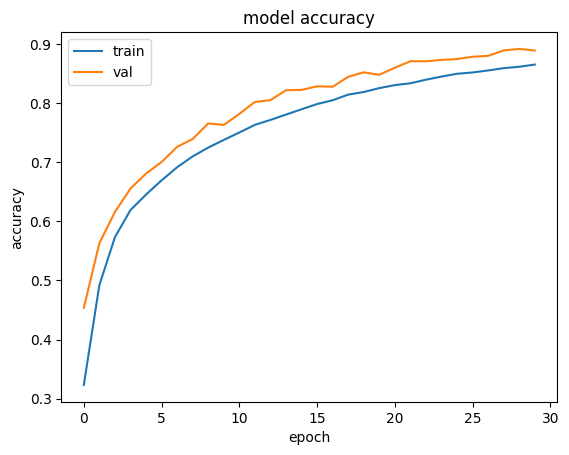

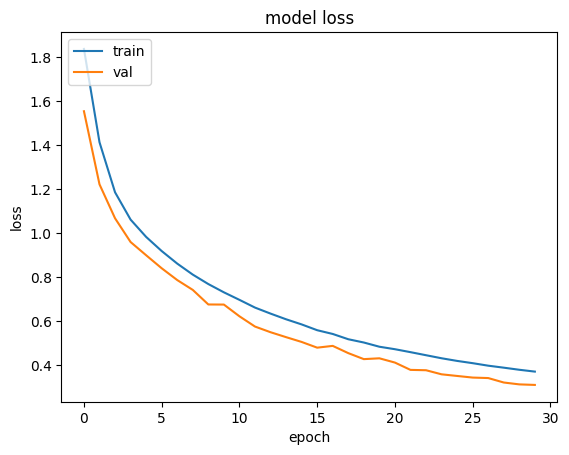

274/274 [==============================] - 0s 1ms/step


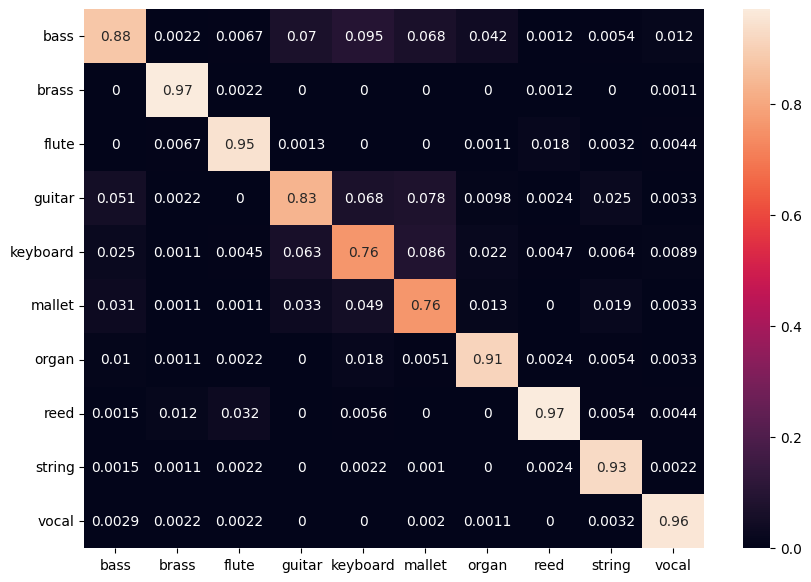

KeyboardInterrupt: 

In [152]:
if (global_model_type == 'cnn'):
    print('Start running cnn')
    run_cnn_5_fold_cross_validation()
else:
    print('Start running lstm')
    run_lstm_5_fold_cross_validation()